In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error

import itertools as it
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image 
import time as time


In [6]:
X_train = pd.read_csv('./Data/X_train.csv')
X_test = pd.read_csv('./Data/X_test.csv')
y_train = pd.read_csv('./Data/y_train.csv')
y_test = pd.read_csv('./Data/y_test.csv')

In [75]:
y_train.head()

,Unnamed: 0,totalyearlycompensation
0,43345,124000
1,29040,161000
2,53119,85000
3,33060,195000
4,31559,245000


In [7]:
y_train = np.log(y_train.totalyearlycompensation)

In [8]:
y_test.head()

,Unnamed: 0,totalyearlycompensation
0,60446,95000
1,51717,125000
2,35471,350000
3,46305,108000
4,25802,113000


In [9]:
y_test = y_test.totalyearlycompensation
y_test_log=np.log(y_test)

In [79]:
X_train.columns

Index(['Unnamed: 0', 'yearsofexperience', 'yearsatcompany', 'Masters_Degree',
       'Bachelors_Degree', 'Doctorate_Degree', 'Highschool', 'Some_College',
       'Race_Asian', 'Race_White',
       ...
       'dmaid_770.0', 'dmaid_789.0', 'dmaid_803.0', 'dmaid_807.0',
       'dmaid_819.0', 'dmaid_820.0', 'dmaid_825.0', 'dmaid_855.0',
       'dmaid_862.0', 'dmaid_other'],
      dtype='object', length=107)

In [ ]:
# naive model
naive_model = RandomForestRegressor(random_state=1).fit(X_train, y_train)

#make preds
naive_pred = naive_model.predict(X_test)
naive_pred_exp = np.exp(naive_pred)
print("naive model MAE:", mean_absolute_error(naive_pred_exp, y_test))

In [70]:
oob_rsquared = {}
test_rsquared = {}
oob_mae = {}
test_mae = {}

for i in np.linspace(50, 1000, 100, dtype=int):
    model = RandomForestRegressor(n_estimators=i, random_state=1, max_features="sqrt",
                                   n_jobs=-1, oob_score=True).fit(X_train, y_train)
    oob_rsquared[i] = model.oob_score_
    oob_mae[i] = mean_absolute_error(model.oob_prediction_, y_train)
    pred = model.predict(X_test)
    pred = np.exp(pred)  # Exponentiate predicted values to get back to original scale
    test_rsquared[i] = r2_score(y_test, pred)  # Calculate R-squared on original scale
    test_mae[i] = mean_absolute_error(pred, y_test)  # Calculate MAE on original scale

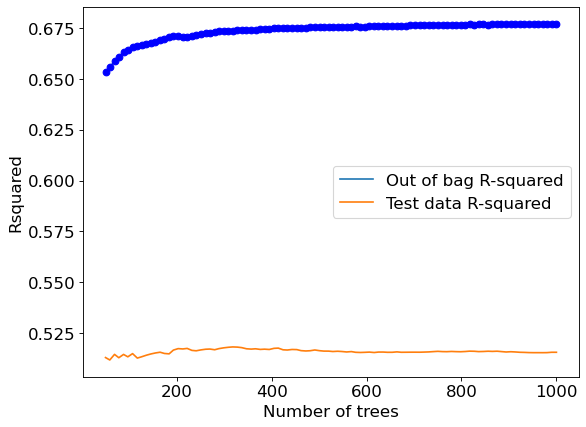

In [71]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rsquared.keys(),oob_rsquared.values(),label = 'Out of bag R-squared')
plt.plot(oob_rsquared.keys(),oob_rsquared.values(),'o',color = 'blue')
plt.plot(test_rsquared.keys(),test_rsquared.values(), label = 'Test data R-squared')
plt.xlabel('Number of trees')
plt.ylabel('Rsquared')
plt.legend()

Looks like the test data r-squared stays pretty constant throughout different # of trees and otu of bag r-squared initially increases a bit and then plateus. The max of test data r-squared is between 200 and 400 tree and the oob r-squared plateaus at around 300-350 trees. Therefore, we should use 350 trees to optimize our model. 

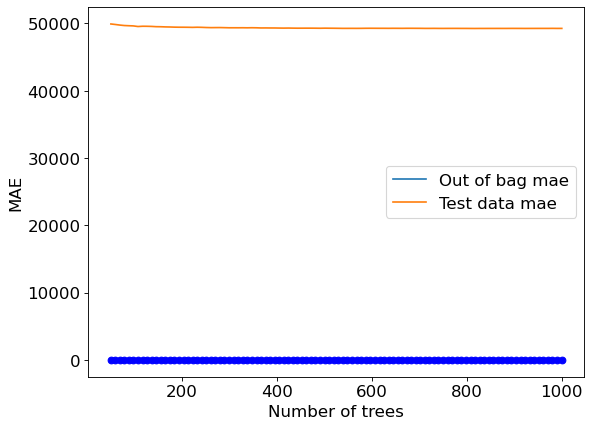

In [72]:
#Visualizing out-of-bag RMSE and test data RMSE
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_mae.keys(),oob_mae.values(),label = 'Out of bag mae')
plt.plot(oob_mae.keys(),oob_mae.values(),'o',color = 'blue')
plt.plot(test_mae.keys(),test_mae.values(), label = 'Test data mae')
plt.xlabel('Number of trees')
plt.ylabel('MAE')
plt.legend()

In [80]:
#Optimizing with OOB score takes half the time as compared to cross validation. 
#The number of models developed with OOB score tuning is one-fifth of the number of models developed with
#5-fold cross validation
start_time = time.time()

n_samples = X_train.shape[0]
n_features = X_train.shape[1]

params = {'n_estimators': [350],
          'max_depth': [12,15,18],
          'max_leaf_nodes':[1100,1200,1300],
          'max_features': [1,2,3,4]}

param_list=list(it.product(*(params[Name] for Name in params)))

oob_score = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestRegressor(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                 max_depth=pr[1],max_leaf_nodes=pr[2],max_features=pr[3],
                                  n_jobs=-1).fit(X_train,y_train)
    oob_score[i] = model.oob_score_
    i=i+1
    
end_time = time.time()
print("time taken = ", (end_time-start_time)/60, " minutes")
print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

time taken =  0.7195482174555461  minutes
Best params =  (350, 18, 1300, 4)
Best score (R-squared) =  0.5635872784461009


we see that the high range of max_depth, max_leaf_nodes, max_features was taken so lets expand those ranges

In [81]:
start_time = time.time()

params = {'n_estimators': [350],
          'max_depth': [18, 20, 22], # expand this out since high range taken
          'max_leaf_nodes':[1300,2000,3000], # expand this out since high range taken
          'max_features': [4,6,8]} # expand this out since high range taken

param_list=list(it.product(*(params[Name] for Name in params)))

oob_score = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestRegressor(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                 max_depth=pr[1],max_leaf_nodes=pr[2],max_features=pr[3],
                                  n_jobs=-1).fit(X_train,y_train)
    oob_score[i] = model.oob_score_
    i=i+1
    
end_time = time.time()
print("time taken = ", (end_time-start_time)/60, " minutes")
print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

time taken =  0.7141302347183227  minutes
Best params =  (350, 22, 3000, 8)
Best score (R-squared) =  0.6626626647839164


In [82]:
start_time = time.time()
params = {'n_estimators': [350],
          'max_depth': [22, 30, 45], # expand this out since high range taken
          'max_leaf_nodes':[3000, 5000, 10000], # expand this out since high range taken
          'max_features': [8, 15, 20]} # expand this out since high range taken

param_list=list(it.product(*(params[Name] for Name in params)))

oob_score = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestRegressor(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                 max_depth=pr[1],max_leaf_nodes=pr[2],max_features=pr[3],
                                  n_jobs=-1).fit(X_train,y_train)
    oob_score[i] = model.oob_score_
    i=i+1
    
end_time = time.time()
print("time taken = ", (end_time-start_time)/60, " minutes")
print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

time taken =  1.166588552792867  minutes
Best params =  (350, 30, 3000, 20)
Best score (R-squared) =  0.683244954570055


In [83]:
start_time = time.time()
params = {'n_estimators': [350],
          'max_depth': [25, 30, 35], 
          'max_leaf_nodes':[2500, 3000, 3500], 
          'max_features': [20, 22, 24]} 

param_list=list(it.product(*(params[Name] for Name in params)))

oob_score = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestRegressor(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                 max_depth=pr[1],max_leaf_nodes=pr[2],max_features=pr[3],
                                  n_jobs=-1).fit(X_train,y_train)
    oob_score[i] = model.oob_score_
    i=i+1
    
end_time = time.time()
print("time taken = ", (end_time-start_time)/60, " minutes")
print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

time taken =  1.3288073301315309  minutes
Best params =  (350, 25, 3500, 20)
Best score (R-squared) =  0.6844298823367385


In [84]:
start_time = time.time()
params = {'n_estimators': [350],
          'max_depth': [22, 25, 27],
          'max_leaf_nodes':[3250, 3500, 3750], 
          'max_features': [18, 19, 20, 21]} 

param_list=list(it.product(*(params[Name] for Name in params)))

oob_score = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestRegressor(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                 max_depth=pr[1],max_leaf_nodes=pr[2],max_features=pr[3],
                                  n_jobs=-1).fit(X_train,y_train)
    oob_score[i] = model.oob_score_
    i=i+1
    
end_time = time.time()
print("time taken = ", (end_time-start_time)/60, " minutes")
print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

time taken =  1.740479596455892  minutes
Best params =  (350, 25, 3250, 20)
Best score (R-squared) =  0.684437852581224


In [85]:
start_time = time.time()
params = {'n_estimators': [350],
          'max_depth': [23, 24, 25, 26, 27],
          'max_leaf_nodes':[3100, 3250, 3400], 
          'max_features': [20]} # set

param_list=list(it.product(*(params[Name] for Name in params)))

oob_score = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestRegressor(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                 max_depth=pr[1],max_leaf_nodes=pr[2],max_features=pr[3],
                                  n_jobs=-1).fit(X_train,y_train)
    oob_score[i] = model.oob_score_
    i=i+1
    
end_time = time.time()
print("time taken = ", (end_time-start_time)/60, " minutes")
print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

time taken =  0.6960430979728699  minutes
Best params =  (350, 25, 3400, 20)
Best score (R-squared) =  0.6845017206648687


In [87]:
#Model with optimal parameters
model = RandomForestRegressor(n_estimators=350, random_state=1,max_leaf_nodes=3100,max_depth=25,
                        oob_score=True,n_jobs=-1, max_features=20).fit(X_train, y_train)

#make preds
pred = model.predict(X_test)
pred_exp = np.exp(pred)
print("MAE:", mean_absolute_error(pred_exp, y_test))

MAE: 48605.669982948835


In [92]:
param_grid = {'max_depth': [23, 24, 25, 26, 27],
            'max_leaf_nodes':[3000, 3250, 3500], 
            'max_features': [18, 20, 22]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)

# setting max depth since not changing much
grid_search = GridSearchCV(estimator=RandomForestRegressor(n_estimators=350, random_state=1), 
                            param_grid=param_grid, verbose=1, n_jobs=-1, cv=cv, scoring='neg_mean_absolute_error')
optimal_params = grid_search.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Optimal parameter values = {'max_depth': 27, 'max_features': 20, 'max_leaf_nodes': 3500}
Optimal cross validation R-squared =  -0.2631609882095366


In [94]:
#Model with optimal parameters
random_forest = RandomForestRegressor(n_estimators=350, random_state=1,max_leaf_nodes=3500,max_depth=27,
                        oob_score=True,n_jobs=-1, max_features=20).fit(X_train, y_train)

#make preds
pred = random_forest.predict(X_test)
pred_exp = np.exp(pred)
print("MAE:", mean_absolute_error(pred_exp, y_test))

MAE: 48582.650837241774


In [96]:
param_grid = {'n_estimators': [300, 325, 350],
            'max_depth': [23, 24, 25, 26, 27],
            'max_leaf_nodes':[3000, 3250, 3500], 
            'max_features': [18, 20, 22]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)

# setting max depth since not changing much
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=1), 
                            param_grid=param_grid, verbose=1, n_jobs=-1, cv=cv, scoring='neg_mean_absolute_error')
optimal_params = grid_search.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Optimal parameter values = {'max_depth': 27, 'max_features': 20, 'max_leaf_nodes': 3500, 'n_estimators': 350}
Optimal cross validation R-squared =  -0.2631609882095366


In [11]:
param_grid = {'n_estimators': [350, 375],
            'max_depth': [25, 26, 27, 28, 29],
            'max_leaf_nodes':[32500, 3500, 3750], 
            'max_features': [18, 20, 22]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)

# setting max depth since not changing much
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=1), 
                            param_grid=param_grid, verbose=1, n_jobs=-1, cv=cv, scoring='neg_mean_absolute_error')
optimal_params = grid_search.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Optimal parameter values = {'max_depth': 25, 'max_features': 22, 'max_leaf_nodes': 3500, 'n_estimators': 375}
Optimal cross validation R-squared =  -0.2631918101024519


In [12]:
#Model with optimal parameters
random_forest2 = RandomForestRegressor(n_estimators=375, random_state=1,max_leaf_nodes=3500,max_depth=25,
                        oob_score=True,n_jobs=-1, max_features=22).fit(X_train, y_train)

#make preds
pred = random_forest2.predict(X_test)
pred_exp = np.exp(pred)
print("MAE:", mean_absolute_error(pred_exp, y_test))

MAE: 48520.13989378257
